<a href="https://colab.research.google.com/github/luisroliveira/projetoSinaisSitemas/blob/main/Processamento_de_audio_(visualiza%C3%A7%C3%A3o).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregando o Banco de dados

In [ ]:
#clonando o repositório da base de dados ESC-50
!git clone https://github.com/karolpiczak/ESC-50.git
import os
import pandas as pd
import librosa, IPython.display
from scipy import signal
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

fatal: destination path 'ESC-50' already exists and is not an empty directory.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 1. Analisando Banco de Dados

In [ ]:
#carregando a Esc50
esc50 = pd.read_csv("/content/ESC-50/meta/esc50.csv")
esc50.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   fold      2000 non-null   int64 
 2   target    2000 non-null   int64 
 3   category  2000 non-null   object
 4   esc10     2000 non-null   bool  
 5   src_file  2000 non-null   int64 
 6   take      2000 non-null   object
dtypes: bool(1), int64(3), object(3)
memory usage: 95.8+ KB


In [ ]:
#selecionando subconjunto da Esc50 , o Esc10
esc10 = esc50[esc50['esc10'] == True]
esc10 = esc10.iloc[:,[i for i in range(0,7) if i != 4]]
esc10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  400 non-null    object
 1   fold      400 non-null    int64 
 2   target    400 non-null    int64 
 3   category  400 non-null    object
 4   src_file  400 non-null    int64 
 5   take      400 non-null    object
dtypes: int64(3), object(3)
memory usage: 21.9+ KB


In [ ]:
# cada fold possui um subconjunto menor do esc10 com os dados balanceados
esc10[esc10["fold"] == 1][["category","filename"]].groupby("category")["category"].count()

category
chainsaw          8
clock_tick        8
crackling_fire    8
crying_baby       8
dog               8
helicopter        8
rain              8
rooster           8
sea_waves         8
sneezing          8
Name: category, dtype: int64

#2. Carregamento de Áudio e operações com Áudio

In [ ]:
from librosa.feature import zero_crossing_rate
# Criação de classe Audio
class Audio:
  # Audio pode ser criado a partir do local onde se encontra
  # ou a partir de um sinal e uma frequencia
  def __init__(self,location = '',sign=[],frequencia=0):
    if location != '':
      sinal, self.frequencia = librosa.load(location)
      self.sinal = np.array(sinal)

      # reduced_noise = nr.reduce_noise(y=sinal, sr=self.frequencia)
      # self.sinal = np.array(reduced_noise)
    else:
      self.sinal = sign
      self.frequencia = frequencia
    self.length = len(self.sinal)

  #mostra o gráfico do sinal de Audio
  def grafico(self):
    librosa.display.waveshow(self.sinal)

  #reproduz o Audio uma frequencia determinada
  def reproduzir(self, frequencia):
    IPython.display.Audio(self.sinal,rate = frequencia)

  #faz uma convolução do sinal de audio com outro sinal
  def convolva(self,sinal_2):
    return signal.fftconvolve(self.sinal,sinal_2,mode="full")

  #divide o audio em janelas com o tamanho e espaçamento determinado
  def janelas(self,tamanho,espacamento):
    for i in range(0,len(self.sinal),espacamento):
      yield Audio(sign = self.sinal[i:i+tamanho], frequencia = self.frequencia)

  #retorna um Audio com o sinal multiplicado por uma janela do tipo determinado
  def windows(self,tipo):
    return Audio(sign = self.sinal*signal.get_window(tipo,self.length),frequencia = self.frequencia)

  def func_fft(self):
    fft_result = np.fft.fft(self.sinal)
    freqs = np.fft.fftfreq(len(fft_result), 1.0 / self.frequencia)
    return fft_result, freqs

  def plot_fft(self, fft_result, freqs):
    plt.figure(figsize=(10, 6))
    plt.plot(freqs[:len(freqs) // 2], np.abs(fft_result[:len(freqs) // 2]))
    plt.xlabel('Frequência (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Espectro de Frequência')
    plt.grid()
    plt.show()

  def func_spectrogram(self):
    n_fft = 2048
    hop_length = 512
    spectrogram_result = librosa.stft(self.sinal, n_fft=n_fft, hop_length=hop_length)
    return spectrogram_result

  def plot_spectrogram(self, spectrogram):
    spectrogram_db = librosa.amplitude_to_db(abs(spectrogram))
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='linear', sr=self.frequencia)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma')
    plt.show()

  def func_spectral_centroid(self):
    n_fft = 2048
    spectral_centroid_result = librosa.feature.spectral_centroid(y=self.sinal, n_fft=n_fft, sr=self.frequencia)
    return np.mean(spectral_centroid_result)

  def func_spectral_flatness(self):
    n_fft = 2048
    flatness_result = librosa.feature.spectral_flatness(y=self.sinal, n_fft=n_fft)
    return np.mean(flatness_result)

  def func_mfcc_custom(self, nFft, hopLength, nMfcc):
    # nFft -> Tamanho da janela fft
    # hopLength -> Tamanho de sobreposição entre as janelas
    # nMfcc -> # Número de coeficientes MFCC a serem extraídos
    mfcc_result = librosa.feature.mfcc(y=self.sinal, sr=self.frequencia, n_fft=nFft, hop_length=hopLength, n_mfcc=nMfcc, window="hamming")
    return mfcc_result

  def plot_mfcc(self, mfcc_result):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc_result, x_axis='time', sr=self.frequencia)
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.show()

  def func_zcr(self):
    zero_crossing = np.where(np.diff(np.sign(self.sinal)))[0]
    zcr_result = len(zero_crossing) / (len(self.sinal) - 1)
    return zcr_result

  def func_pr(self):
    pitch, voiced_flag, voiced_probs = librosa.pyin(self.sinal, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    # print(voiced_flag)
    # print(voiced_probs)
    # print(pitch)
    print(f"pitch: {pitch[voiced_flag]}")
    pitch = pitch[voiced_flag]
    pitch_range = np.max(pitch) - np.min(pitch)
    print(f"Pitch range: {pitch_range}")
    return pitch_range

  def correlacao(self,margem):
    amostrasCorrelacao = math.ceil(((1/20)/self.duracao())*len(self.sinal))
    correlacao = np.correlate(self.sinal,self.sinal,"full")

    inicio = math.floor(len(correlacao)/2)
    fim = inicio + amostrasCorrelacao

    return correlacao[inicio - margem:fim + margem]
  def duracao(self):
    return len(self.sinal)/self.frequencia
  def pitch(self):
    # Obtendo a correlação do sinal
    corr = self.correlacao(0)
    # Encontrando quando ocorre os picos positivos do sinal
    peaks = [x for x in  signal.find_peaks(corr)[0] if corr[x] > 0]

    len_peaks = len(peaks)
    if(len_peaks < 2 ): return math.nan

    # Calculando pitch
    qtd_amostras = (peaks[len_peaks-1] - peaks[0])/(len_peaks-1)
    pitch = self.frequencia/qtd_amostras

    return pitch

# 3. Extraindo Características

## A. Principais Funcões

In [ ]:
def restricao(win,sign):
  if(np.max(win.sinal) < 0.06*np.max(sign.sinal)):
    return False
  return True
# recebe um banco de dados e um array com as
# caracteristicas a serem extraidas das janelas
# de tamanho e espacamento especificados
# e retorna um banco de dados com as caracteristicas
# o nome da caracteristica dentro do array passado como imput
# DEVE ser igual ao nome fo método que extrai essa característica
# na classe Audio

def extrairCaracteristicas(bd,Caracteristicas,tamanho,espacamento,inc_freq):
  bd = bd.reset_index(drop= True)
  dados = []
  colunas =[]
  # iterando por cada audio no banco de dados
  for i in bd.index:

    audio = Audio("/content/ESC-50/audio/" + bd["filename"].iloc[i])
    num_win = -1
    dados.append([])

    #iterando por cada janela do sinal de audio
    for win in audio.janelas(tamanho,espacamento):

      num_win += 1

      for caracter in Caracteristicas:
        # Uma característica para cada janela do sinal
        caracteristica = caracter + str(num_win)
        if(restricao(win,audio)):
          # Se a coluna com a característica não tiver sido criada, ela é criada
          if caracteristica not in colunas:
            colunas.append(caracteristica)

          # Extrai a caracteristicas da janela e insere no banco de dados na linha do audio
          extrator = getattr(Audio,caracter)
          dados[i].append(extrator(win.windows("hann")))
        else:
          dados[i].append(np.nan)
    if(inc_freq):
      mfcc_arr = np.median(audio.func_mfcc_custom(tamanho, espacamento, 13), axis = 1)
      dados[i] = np.concatenate((dados[i], mfcc_arr[1:]), axis = 0)

  if(inc_freq):
    for j in range(1, 13):
      colunas.append(f"mfcc{j}")

  bdC = pd.DataFrame(dados,columns= colunas)
  return  pd.concat([bd,bdC],axis = 1)

## B. Extraindo Caracteristicas

In [ ]:
dFrame = extrairCaracteristicas(esc10,["pitch","func_zcr","func_spectral_centroid","func_spectral_flatness"],500,250, True)
dFrame = dFrame.drop(columns = ["fold","target","src_file","take","filename"])
dFrame

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=500
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=250
  warnings.warn(


,category,pitch199,func_zcr199,func_spectral_centroid199,func_spectral_flatness199,pitch200,func_zcr200,func_spectral_centroid200,func_spectral_flatness200,pitch201,...,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12
0,dog,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,dog,NaN,NaN,NaN,NaN,1060.983264,0.062124,1048.875322,0.001349,967.105263,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,chainsaw,793.573265,0.102204,1880.202519,0.012976,793.165468,0.094188,2325.705895,0.035108,733.120205,...,10.478933,-27.508472,-1.612104,-18.031322,4.700795,-9.151062,8.443730,-7.560451,-4.305366,-7.783374
3,crackling_fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.858793,27.558075,9.375027,0.462985,23.251226,-5.864016,4.957283,-1.617016,5.523302,-5.065298
4,helicopter,4374.291498,0.284569,4584.221100,0.110319,5927.902240,0.328657,4678.539179,0.131276,5814.401623,...,24.340168,10.032442,16.919151,-7.429797,12.254519,5.832973,-0.164153,0.008921,6.836418,-1.000934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,rooster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.687903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
396,rooster,NaN,NaN,NaN,NaN,1053.134328,0.108216,2526.052801,0.024498,2360.813704,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
397,rooster,1121.186441,0.112224,2349.795059,0.032703,1160.526316,0.106212,2114.916102,0.012573,1070.860927,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
398,clock_tick,NaN,0.012024,645.285305,0.000273,NaN,0.022044,664.716292,0.000272,NaN,...,27.168068,19.350372,22.881584,13.225063,11.574214,12.649946,14.485812,9.412497,9.878983,9.595251


In [ ]:
MFCCs = [x for x in dFrame.columns if x.__contains__("mfcc") ]
Centroid = [x for x in np.array(dFrame.columns) if x.__contains__("centroid")]
Flatness = [x for x in np.array(dFrame.columns) if x.__contains__("flatness")]
Pitch = [x for x in np.array(dFrame.columns) if x.__contains__("pitch")]
Zcr = [x for x in np.array(dFrame.columns) if x.__contains__("zcr")]

pitch = dFrame.replace(0,math.nan)[Pitch]
zcr = dFrame.replace(0,math.nan)[Zcr]
centroid = dFrame[Centroid]
flatness = dFrame[Flatness]


dFrame["Pitch_Ratio"] = pitch.max(axis = 1)/pitch.min(axis = 1)
dFrame["Pitch_Standard_Deviation"] = pitch.std(axis=1, numeric_only=True)/pitch.mean(axis = 1)

dFrame["Zcr_Mean"] = zcr.mean(axis=1)
dFrame["Zcr_Mean_Deviation"] = zcr.std(axis=1, numeric_only=True)/zcr.mean(axis = 1)

dFrame["Centroid_Mean"] = flatness.mean(axis=1)
dFrame["Centroid_Deviation"] = flatness.std(axis=1, numeric_only=True)/flatness.mean(axis = 1)

dFrame["Flatness_Mean"] = centroid.mean(axis=1)
dFrame["Flatness_Deviation"] = centroid.std(axis=1, numeric_only=True)/centroid.mean(axis = 1)

#4. Classificação

## Funções gerais

### Separação Treino - Teste

In [ ]:
def train_test(dFrame):
  features = dFrame.drop(columns = "category")
  outcomes = dFrame["category"]

  rnd_seed = 12
  train_ratio = 0.7  #Proporção de casos de treinamento

  return train_test_split(features, outcomes, random_state = rnd_seed, train_size = train_ratio)

### Resultados das métricas

In [ ]:
def Metrics_Results(outcomes_expected, outcomes_predicted):

  ConfusionMatrixDisplay.from_predictions(outcomes_expected, outcomes_predicted, cmap = "Blues", xticks_rotation = 60)
  plt.show()

  print("\n\n\n\n", classification_report(outcomes_expected, outcomes_predicted))

  plt.show()


### Classificação usando SVM

In [ ]:
def Classification(dFrame, c):

  features_train, features_test, outcomes_train, outcomes_test = train_test(dFrame)

  SVM = make_pipeline(StandardScaler(), SVC(kernel = 'rbf', C = c, decision_function_shape = "ovr"))
  SVM.fit(features_train, outcomes_train)
  outcomes_predicted = SVM.predict(features_test)

  Metrics_Results(outcomes_test, outcomes_predicted)

  return features_train, features_test, outcomes_train, outcomes_test, SVM

### Escolha de classes para filtrar

In [ ]:
def filter_classes(dFrame, c):
  dFrameS = dFrame[~dFrame["category"].isin(["clock_tick", "rooster","chainsaw", "dog", "helicopter"])]
  return Classification(dFrameS, c)

## Testes com todas as classes

### Base Completa





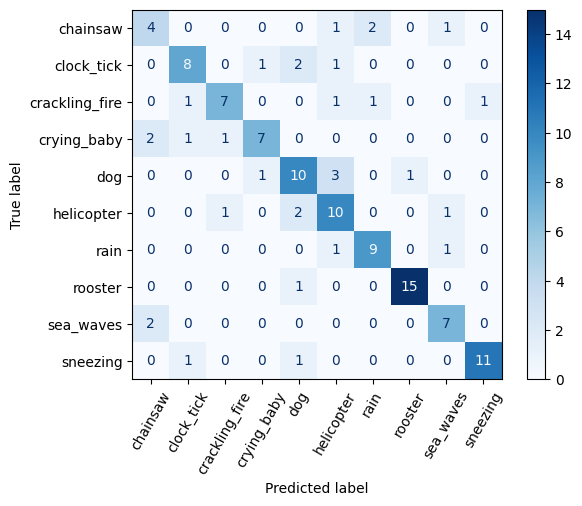





                 precision    recall  f1-score   support

      chainsaw       0.50      0.50      0.50         8
    clock_tick       0.73      0.67      0.70        12
crackling_fire       0.78      0.64      0.70        11
   crying_baby       0.78      0.64      0.70        11
           dog       0.62      0.67      0.65        15
    helicopter       0.59      0.71      0.65        14
          rain       0.75      0.82      0.78        11
       rooster       0.94      0.94      0.94        16
     sea_waves       0.70      0.78      0.74         9
      sneezing       0.92      0.85      0.88        13

      accuracy                           0.73       120
     macro avg       0.73      0.72      0.72       120
  weighted avg       0.74      0.73      0.73       120



In [ ]:
dFrame = dFrame.replace(np.nan,0)

ret = Classification(dFrame,4)

### Base com médias e desvio padrão do pich e zcr, mffcs, médias e desvio do centroid e flatness

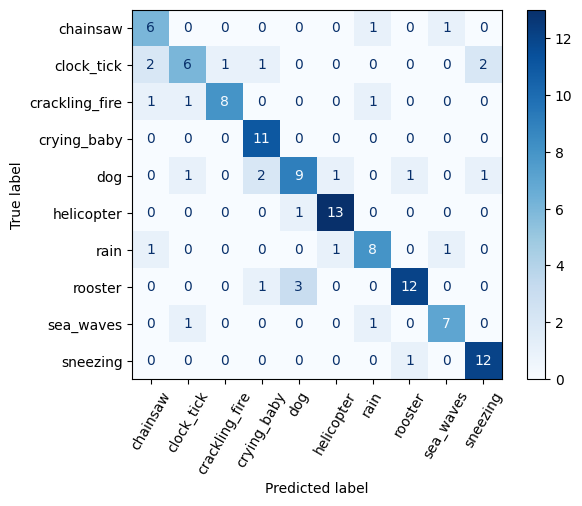





                 precision    recall  f1-score   support

      chainsaw       0.60      0.75      0.67         8
    clock_tick       0.67      0.50      0.57        12
crackling_fire       0.89      0.73      0.80        11
   crying_baby       0.73      1.00      0.85        11
           dog       0.69      0.60      0.64        15
    helicopter       0.87      0.93      0.90        14
          rain       0.73      0.73      0.73        11
       rooster       0.86      0.75      0.80        16
     sea_waves       0.78      0.78      0.78         9
      sneezing       0.80      0.92      0.86        13

      accuracy                           0.77       120
     macro avg       0.76      0.77      0.76       120
  weighted avg       0.77      0.77      0.76       120



In [ ]:
Frame = dFrame[["category"]+ ["Centroid_Mean","Centroid_Deviation","Flatness_Mean","Flatness_Deviation","Pitch_Ratio","Pitch_Standard_Deviation","Zcr_Mean","Zcr_Mean_Deviation"] + MFCCs]

ret = Classification(Frame.replace(np.nan,0),3)

### Bases só com caracteristicas temporais

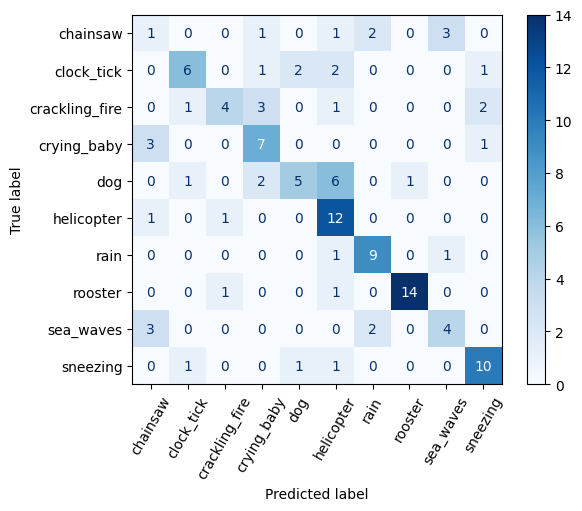





                 precision    recall  f1-score   support

      chainsaw       0.12      0.12      0.12         8
    clock_tick       0.67      0.50      0.57        12
crackling_fire       0.67      0.36      0.47        11
   crying_baby       0.50      0.64      0.56        11
           dog       0.62      0.33      0.43        15
    helicopter       0.48      0.86      0.62        14
          rain       0.69      0.82      0.75        11
       rooster       0.93      0.88      0.90        16
     sea_waves       0.50      0.44      0.47         9
      sneezing       0.71      0.77      0.74        13

      accuracy                           0.60       120
     macro avg       0.59      0.57      0.56       120
  weighted avg       0.62      0.60      0.59       120



In [ ]:
Frame_time = dFrame[["category"]+ Zcr + Pitch]

ret = Classification(Frame_time.replace(np.nan,0),200)

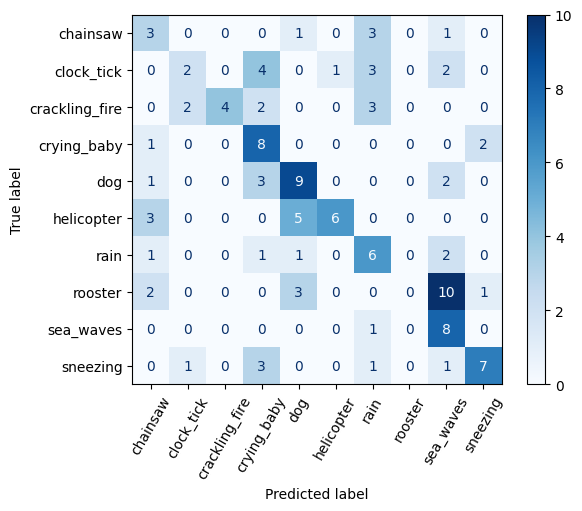





                 precision    recall  f1-score   support

      chainsaw       0.27      0.38      0.32         8
    clock_tick       0.40      0.17      0.24        12
crackling_fire       1.00      0.36      0.53        11
   crying_baby       0.38      0.73      0.50        11
           dog       0.47      0.60      0.53        15
    helicopter       0.86      0.43      0.57        14
          rain       0.35      0.55      0.43        11
       rooster       0.00      0.00      0.00        16
     sea_waves       0.31      0.89      0.46         9
      sneezing       0.70      0.54      0.61        13

      accuracy                           0.44       120
     macro avg       0.47      0.46      0.42       120
  weighted avg       0.48      0.44      0.41       120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Frame_time2 = dFrame[["category"] + ["Zcr_Mean","Zcr_Mean_Deviation","Pitch_Ratio","Pitch_Standard_Deviation"]]

ret = Classification(Frame_time2.replace(np.nan,0),2)

### Bases só com características espectrais

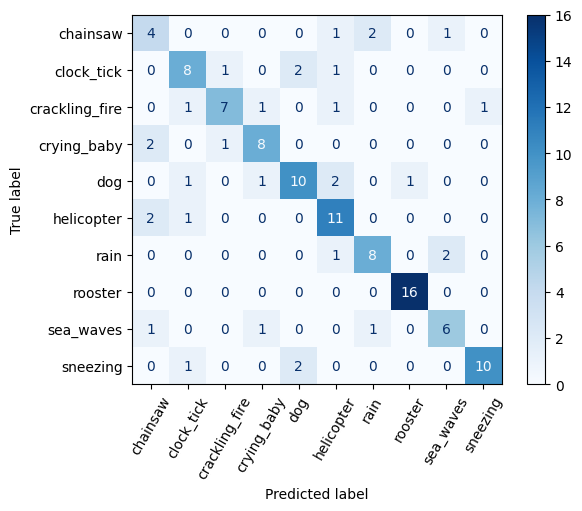





                 precision    recall  f1-score   support

      chainsaw       0.44      0.50      0.47         8
    clock_tick       0.67      0.67      0.67        12
crackling_fire       0.78      0.64      0.70        11
   crying_baby       0.73      0.73      0.73        11
           dog       0.71      0.67      0.69        15
    helicopter       0.65      0.79      0.71        14
          rain       0.73      0.73      0.73        11
       rooster       0.94      1.00      0.97        16
     sea_waves       0.67      0.67      0.67         9
      sneezing       0.91      0.77      0.83        13

      accuracy                           0.73       120
     macro avg       0.72      0.71      0.72       120
  weighted avg       0.74      0.73      0.73       120



In [ ]:
dFrame_Centroid_Flatness_Mfccs = dFrame.replace(math.nan,0)[["category"] + Centroid + Flatness + MFCCs]

ret = Classification(dFrame_Centroid_Flatness_Mfccs,4)

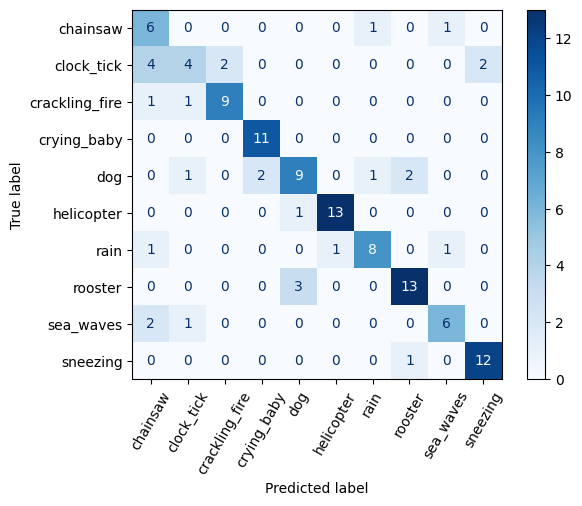





                 precision    recall  f1-score   support

      chainsaw       0.43      0.75      0.55         8
    clock_tick       0.57      0.33      0.42        12
crackling_fire       0.82      0.82      0.82        11
   crying_baby       0.85      1.00      0.92        11
           dog       0.69      0.60      0.64        15
    helicopter       0.93      0.93      0.93        14
          rain       0.80      0.73      0.76        11
       rooster       0.81      0.81      0.81        16
     sea_waves       0.75      0.67      0.71         9
      sneezing       0.86      0.92      0.89        13

      accuracy                           0.76       120
     macro avg       0.75      0.76      0.74       120
  weighted avg       0.76      0.76      0.75       120



In [ ]:
dFrame_CentroidMean_FlatnessMean_Mfccs = dFrame.replace(math.nan,0)[["category"]+ ["Centroid_Mean","Centroid_Deviation","Flatness_Mean","Flatness_Deviation"] + MFCCs]

ret = Classification(dFrame_CentroidMean_FlatnessMean_Mfccs,3)

## Testes após filtragem de classes

### Base Completa





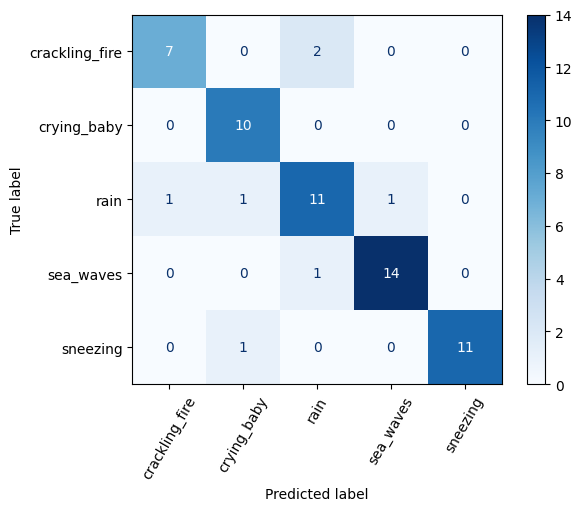





                 precision    recall  f1-score   support

crackling_fire       0.88      0.78      0.82         9
   crying_baby       0.83      1.00      0.91        10
          rain       0.79      0.79      0.79        14
     sea_waves       0.93      0.93      0.93        15
      sneezing       1.00      0.92      0.96        12

      accuracy                           0.88        60
     macro avg       0.89      0.88      0.88        60
  weighted avg       0.89      0.88      0.88        60



In [ ]:
ret = filter_classes(dFrame,4)

### Base com médias e desvio padrão do pich e zcr, mffcs, médias e desvio do centroid e flatness

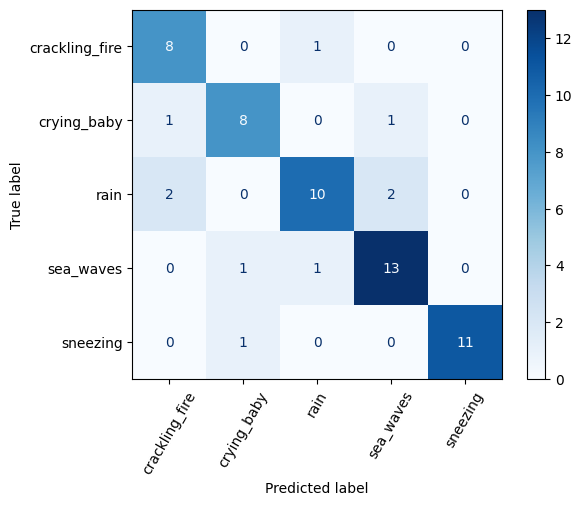





                 precision    recall  f1-score   support

crackling_fire       0.73      0.89      0.80         9
   crying_baby       0.80      0.80      0.80        10
          rain       0.83      0.71      0.77        14
     sea_waves       0.81      0.87      0.84        15
      sneezing       1.00      0.92      0.96        12

      accuracy                           0.83        60
     macro avg       0.83      0.84      0.83        60
  weighted avg       0.84      0.83      0.83        60



In [ ]:
ret = filter_classes(Frame.replace(np.nan,0),3)

### Bases só com caracteristicas temporais

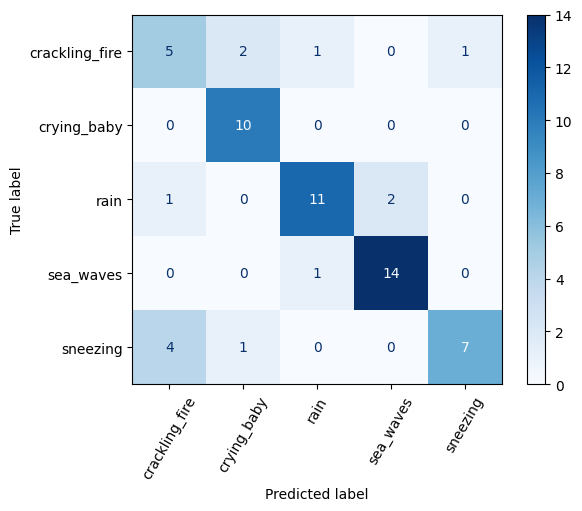





                 precision    recall  f1-score   support

crackling_fire       0.50      0.56      0.53         9
   crying_baby       0.77      1.00      0.87        10
          rain       0.85      0.79      0.81        14
     sea_waves       0.88      0.93      0.90        15
      sneezing       0.88      0.58      0.70        12

      accuracy                           0.78        60
     macro avg       0.77      0.77      0.76        60
  weighted avg       0.79      0.78      0.78        60



In [ ]:
ret = filter_classes(Frame_time.replace(np.nan,0),200)

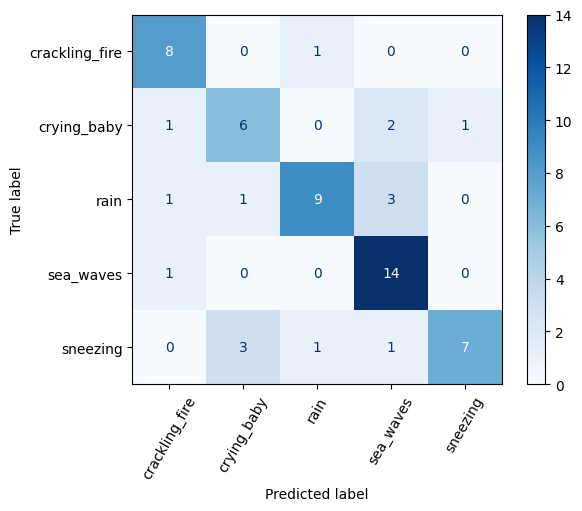





                 precision    recall  f1-score   support

crackling_fire       0.73      0.89      0.80         9
   crying_baby       0.60      0.60      0.60        10
          rain       0.82      0.64      0.72        14
     sea_waves       0.70      0.93      0.80        15
      sneezing       0.88      0.58      0.70        12

      accuracy                           0.73        60
     macro avg       0.74      0.73      0.72        60
  weighted avg       0.75      0.73      0.73        60



In [ ]:
ret = filter_classes(Frame_time2.replace(np.nan,0),2)

### Bases só com características espectrais

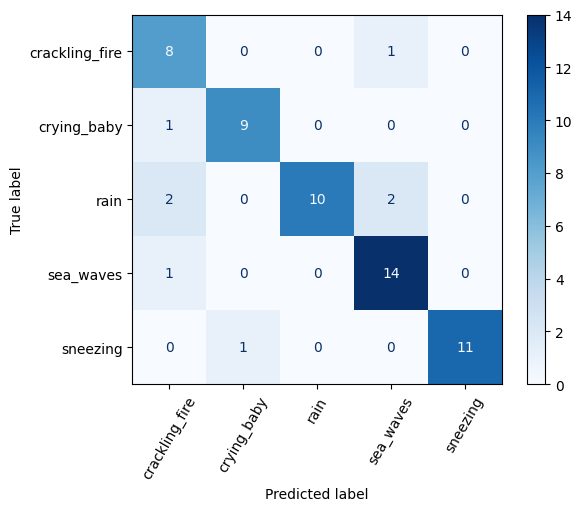





                 precision    recall  f1-score   support

crackling_fire       0.67      0.89      0.76         9
   crying_baby       0.90      0.90      0.90        10
          rain       1.00      0.71      0.83        14
     sea_waves       0.82      0.93      0.87        15
      sneezing       1.00      0.92      0.96        12

      accuracy                           0.87        60
     macro avg       0.88      0.87      0.87        60
  weighted avg       0.89      0.87      0.87        60



In [ ]:
ret = filter_classes(dFrame_Centroid_Flatness_Mfccs,4)

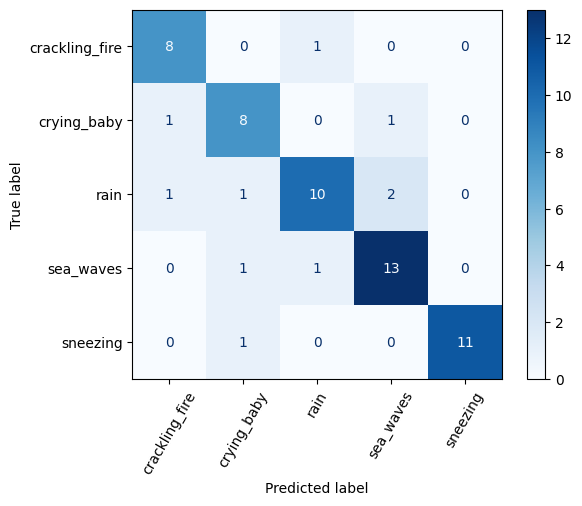





                 precision    recall  f1-score   support

crackling_fire       0.80      0.89      0.84         9
   crying_baby       0.73      0.80      0.76        10
          rain       0.83      0.71      0.77        14
     sea_waves       0.81      0.87      0.84        15
      sneezing       1.00      0.92      0.96        12

      accuracy                           0.83        60
     macro avg       0.83      0.84      0.83        60
  weighted avg       0.84      0.83      0.83        60



In [ ]:
ret = filter_classes(dFrame_CentroidMean_FlatnessMean_Mfccs,3)